## Test CNN

The objective of this notebook is test the usability of the processed data in a toy CNN

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import shutil
import json
import math
from datetime import datetime

# Todo
# Clean libraries here

Load model parameters:

In [2]:
# Do not touch the value of PARAMETERS_FILE!
# When this notebook is executed with jupyter-nbconvert (from script), 
# it will be replaced outomatically
#PARAMETERS_FILE = 'dont_touch_me-input_parameters_file'
PARAMETERS_FILE = '/home/hhughes/Documents/Master_Thesis/Project/workspace/scripts/Parameters/model_params/parameters_test_local.json'
if not os.path.exists(PARAMETERS_FILE):
    raise Exception('Parameter file {} does not exist!'.format(PARAMETERS_FILE))
    
# Open parameters
with open(PARAMETERS_FILE) as params_file:
    p = json.load(params_file)
p.keys()

dict_keys(['_comment', 'model_path', 'external_libs_path', 'pp_path', 'local_tf_datasets', 'tf_ds_name', 'shuffle_files', 'random_horizontal_flipping', 'random_90deg_rotations', 'log_file_name', 'log_level', 'disable_gpu', 'set_memory_growth', 'model_name', 'number_of_epochs', 'seed', 'input_channels'])

Create dirs where model output will be saved:

In [3]:
# Check if path where model instances are saved exist
"""
try:
    os.makedirs(p['model_path'], exist_ok=True)
except OSError as e:
    msg  = 'Dir {} could not be created!\n\nOSError: {}'.format(p['model_path'], e)
    raise Exception(msg)
    
# Create directory where this execution will be saved (tagged with the date and time)
time_tag = datetime.now().strftime("%d%m%y_%H%M")
base_path = os.path.join(p['model_path'], time_tag)
if os.path.exists(base_path):
    msg = 'Warning! Directory {} already exist! Deleting...\n'.format(base_path)
    print(msg)
    try:
        shutil.rmtree(base_path)
    except OSError as e:
        msg  = 'Dir {} could not be deleted!\n\nOSError: {}'.format(base_path, e)
        raise Exception(msg)
    msg = 'Creating dir: {}'.format(base_path)
    print(msg)
    os.makedirs(base_path, exist_ok=False)

# Create dir for model and checkpoint saiving
model_path = os.path.join(base_path, 'model')
try:
    os.makedirs(model_path, exist_ok=False)
except:
    msg  = 'Dir {} could not be created!'.format(model_path)
    raise Exception(msg)
    
checkpoints_path = os.path.join(base_path, 'checkpoints')
try:
    os.makedirs(checkpoints_path, exist_ok=False)
except:
    msg  = 'Dir {} could not be created!'.format(checkpoints_path)
    raise Exception(msg)
"""

'\ntry:\n    os.makedirs(p[\'model_path\'], exist_ok=True)\nexcept OSError as e:\n    msg  = \'Dir {} could not be created!\n\nOSError: {}\'.format(p[\'model_path\'], e)\n    raise Exception(msg)\n    \n# Create directory where this execution will be saved (tagged with the date and time)\ntime_tag = datetime.now().strftime("%d%m%y_%H%M")\nbase_path = os.path.join(p[\'model_path\'], time_tag)\nif os.path.exists(base_path):\n    msg = \'Warning! Directory {} already exist! Deleting...\n\'.format(base_path)\n    print(msg)\n    try:\n        shutil.rmtree(base_path)\n    except OSError as e:\n        msg  = \'Dir {} could not be deleted!\n\nOSError: {}\'.format(base_path, e)\n        raise Exception(msg)\n    msg = \'Creating dir: {}\'.format(base_path)\n    print(msg)\n    os.makedirs(base_path, exist_ok=False)\n\n# Create dir for model and checkpoint saiving\nmodel_path = os.path.join(base_path, \'model\')\ntry:\n    os.makedirs(model_path, exist_ok=False)\nexcept:\n    msg  = \'Dir {} 

In [4]:
base_path = '/home/hhughes/Documents/Master_Thesis/Project/workspace/models/baseline_model/model_test'
model_path = os.path.join(base_path, 'model')
checkpoints_path = os.path.join(base_path, 'checkpoints')

Set logging:

In [5]:
# Set logging configuration
import logging
log_file_path = os.path.join(base_path, p['log_file_name'])
logging.basicConfig(
    filename=log_file_path,
    filemode='w', 
    level=getattr(logging, p['log_level'])
)
logging.info('Parameters loaded from file:\n{}'.format(PARAMETERS_FILE))

Load and set external libraries path:

In [6]:
# Load external libraries path
EXTERNAL_LIBS_PATH = p['external_libs_path']
if not os.path.exists(EXTERNAL_LIBS_PATH):
    msg = 'External library path {} does not exist!'.format(EXTERNAL_LIBS_PATH)
    logging.error(msg)
    raise Exception(msg)
else:
    msg='EXTERNAL_LIBS_PATH: {}'.format(EXTERNAL_LIBS_PATH)
    logging.info(msg)
    print(msg)
# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
sys.path.insert(1, EXTERNAL_LIBS_PATH)
# Load external libraries
from Models import Predef_models as predef_models
from Utils import Tee_Logger as Tee_Logger

EXTERNAL_LIBS_PATH: /home/hhughes/Documents/Master_Thesis/Project/workspace/libs


In [7]:
# Make tf to ignore GPU
if p['disable_gpu']:
    msg = "Cuda devices (GPUs) disabled"
    logging.info(msg)
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
msg = 'Physical GPU devises:\n{}'.format(physical_devices)
logging.info(msg)
print(msg)

#restrict GPU mem
if p['set_memory_growth']:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        msg = 'GPU Memory limited!'
    except:
        msg = 'It was not possible to limit GPU memory'
        
    logging.info(msg)
    print(msg)

Physical GPU devises:
[]
It was not possible to limit GPU memory


## Load Preprocessing parameters and information:

In [8]:
# Preprocessed data path
pp_path = p['pp_path']

with open(os.path.join(pp_path, 'params.json')) as pp_file:
    pp_params = json.load(pp_file)
msg = 'Loaded data preprocessing parameters from:\n{}'.format(pp_file)
logging.info(msg)
seed = pp_params['seed']

# Load Channels file
with open(os.path.join(pp_path, 'channels.csv')) as channel_file:
    channels = pd.read_csv(channel_file)
msg = 'Loaded channels file from:\n{}'.format(channel_file)
logging.info(msg)

## Specify input channels

In [9]:
selected_channels = p['input_channels']
msg = 'Selected input channels:\n{}'.format(selected_channels)
logging.info(msg)
print(msg)
# Get selected channel ids
input_ids = np.array(channels.set_index(['name']).loc[selected_channels].channel_id.values)
msg = 'Corresponding input channel ids:\n{}'.format(input_ids)
logging.info(msg)
print(msg)

Selected input channels:
['00_DAPI', '07_H2B', '01_CDK9_pT186', '03_CDK9', '05_GTF2B', '07_SETD1A', '08_H3K4me3', '09_SRRM2', '10_H3K27ac', '11_KPNA2_MAX', '12_RB1_pS807_S811', '13_PABPN1', '14_PCNA', '15_SON', '16_H3', '17_HDAC3', '19_KPNA1_MAX', '20_SP100', '21_NCL', '01_PABPC1', '02_CDK7', '03_RPS6', '05_Sm', '07_POLR2A', '09_CCNT1', '10_POL2RA_pS2', '11_PML', '12_YAP1', '13_POL2RA_pS5', '15_U2SNRNPB', '18_NONO', '20_ALYREF', '21_COIL']
Corresponding input channel ids:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]


## Load Dataset

In [10]:
# Path where tf datasets are
dataset, metadata = tfds.load(
    name=p['tf_ds_name'], 
    data_dir=p['local_tf_datasets'], 
    # If False, returns a dictionary with all the features
    as_supervised=True, 
    shuffle_files=True,
    with_info=True)
msg = 'Tensorflow dataset {} loaded from:\n{}'.format(p['tf_ds_name'], p['local_tf_datasets'])
logging.info(msg)

# Load the splits
train_data, val_data, test_data = dataset['train'], dataset['validation'], dataset['test']

Show information about the dataset:

In [11]:
metadata

tfds.core.DatasetInfo(
    name='mpp_dataset',
    version=1.0.1,
    description='Dataset containing images of Multiplexed protein maps.
The elements of this data sets are multichannel images of singel cells alongside with its transcription rate.
This Dataset was builded after a preprocessing using the python script Transform_MPPData_into_images_from_script.ipynb. During this preprocessing the original MPPData was:
- Converted into images.
- Cleaned. Border and mitotic cells were removed.
- Normalized. Each channel was normalized using scale parameters obtained from the training set.
- Target value (scalar) calculated. The transcription rate was approximated taking the average of the measured pixels of the channel 00_EU. It is important to mention that the the target value was calculated BEFORE the normalization process.

input_channels:
['00_DAPI', '07_H2B', '01_CDK9_pT186', '03_CDK9', '05_GTF2B', '07_SETD1A', '08_H3K4me3', '09_SRRM2', '10_H3K27ac', '11_KPNA2_MAX', '12_RB1_pS807_S811

## Process the data
Before training the network, we discriminate some channels, apply some linear transformations (90deg rotations and horizontal flipping) to augment the **Training** dataset, create the batches and shuffle them. Also, we perform other operations to improve performance.

**Tune performance**<br>
tf.data.Dataset.prefetch overlaps data preprocessing and model execution while training.
It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to **tf.data.experimental.AUTOTUNE** which will prompt the tf.data runtime to tune the value dynamically at runtime.

**Shuffling**<br>
dataset.shuffle() Randomly shuffles the elements of this dataset.
This dataset fills a buffer with `buffer_size` elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then `shuffle` will initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.

**reshuffle_each_iteration** controls whether the shuffle order should be different for each epoch.

In [12]:
# Source:
# https://www.tensorflow.org/tutorials/images/data_augmentation

def filter_channels(image, target):
    """Function to discriminated undecired channels"""
    
    image = tf.cast(image, dtype=tf.float32)
    
    n_channels = metadata.features['image'].shape[-1]
    n_selected_channels = input_ids.shape[-1]
    
    # Create projection matrix base on selected channels
    projection_tensor = np.zeros((n_channels, n_selected_channels))
    for col, row in enumerate(input_ids):
        projection_tensor[row,col] = 1
    projection_tensor = tf.constant(projection_tensor, dtype=tf.float32)
    
    new_shape = image.shape[:-1]+(n_selected_channels,)
    
    return tf.reshape(tf.reshape(image, (-1,n_channels)) @ projection_tensor, (new_shape)), target

def augment(image, target):
    """Function to augment dataset. After channel filtering, it flips (horizontally) and rotates (0, 90, 180, 270 degrees) randomly the images."""
    
    image, target = filter_channels(image, target)
    
    # random Left and right flip
    if p['random_horizontal_flipping']:
        image = tf.image.random_flip_left_right(image)
        
    # random rotations
    # Number of 90deg rotation
    if p['random_90deg_rotations']:
        k = np.random.randint(0,4)
        image = tf.image.rot90(image, k=k)
    
    return image, target

In [13]:
msg = ''
if p['random_horizontal_flipping']:
    msg = 'Random horizontal flipping for training set selected!'
if p['random_90deg_rotations']:
    msg = msg + '\nRandom 90 degrees rotations (0, 90, 180 or 270 deg) for training set selected!'
if msg == '':
    msg = 'No data augmentation technique selected for trainingset!'
logging.info(msg)
print(msg)

No data augmentation technique selected for trainingset!


Take a look into one image and a random transformation (random rotation+random horizontal flippig):

In [14]:
def visualize_cell(image):
    plt.figure(figsize=(6,4))
    plt.title('Original Cell')
    plt.imshow(image.numpy()[:,:,10:13],
               cmap=plt.cm.PiYG,
               vmin=0, vmax=1)
    
    if p['random_horizontal_flipping'] | p['random_90deg_rotations']:
        plt.figure(figsize=(15,4))
        for i in range(4):
            img, _ = augment(image, 0)
            plt.subplot(1,4,i+1)
            plt.title('Augmented Cell')
            plt.imshow(img.numpy()[:,:,10:13],
                       cmap=plt.cm.PiYG,
                       vmin=0, vmax=1)

In [15]:
# Get one image from the training dataset
image, _ = next(iter(train_data))

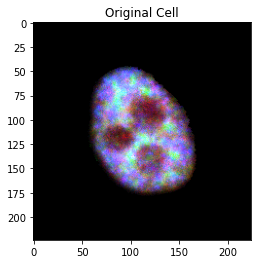

In [16]:
# Visualize the original vs. random flipping and rotations
visualize_cell(image)

Prepare datasets for training the CNN:

In [17]:
BATCH_SIZE = 32
buffer_size = 512
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = (
    train_data
    # since cache keeps images in memory, not shure if this will somehow avoid augmentation
    #.cache()
    .shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_data = (
    val_data
    #.cache()
    .map(filter_channels, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_data = (
    test_data
    #.cache()
    .map(filter_channels, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

## Model Selection

Models are selected from a group of predefined models in the class `Predef_models` (in `Models.py`). The name of the selected model is specified in the parameter `p['model_method']`.

First we need to init the `Predef_models` class:

In [18]:
# Init models class
models = predef_models()

# Select model
img_shape = metadata.features['image'].shape[:-1] + (input_ids.shape[0],)
model = models.select_model(model_name=p['model_name'], input_shape=img_shape)

Base line model selected!


In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.Huber(delta=1.0),
              #loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse', 'mean_absolute_error']
              #metrics=['mse']
             )
msg = 'Model compiled'
logging.info(msg)

Take a look into the model architecture and number of parameters:

In [20]:
# Duplicates sys.stdout to the log file
TeeLog = Tee_Logger(log_file_path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      19072     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               102760704 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

In [21]:
# Finish stdout duplication
TeeLog.close()

Redirect the systems standard output to the logfile, so we can see the training process in the server:

Set callback to save best model:

In [22]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoints_path+'/checkpoint',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_freq='epoch',
    save_best_only=True,
)

Train the model:

In [23]:
msg = 'Starting model training...'
logging.info(msg)

# Duplicates sys.stdout to the log file
TeeLog = Tee_Logger(log_file_path)

# Fit model
n_train = metadata.splits['train'].num_examples
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=p['number_of_epochs'],
                    callbacks=[model_checkpoint_callback],
                    verbose=2,
                    #steps_per_epoch=math.ceil(n_train/BATCH_SIZE),
                    )

Epoch 1/3
31/31 - 89s - loss: 106.0514 - mse: 19567.8223 - mean_absolute_error: 106.5512 - val_loss: 72.6996 - val_mse: 7496.7031 - val_mean_absolute_error: 73.1996
Epoch 2/3
31/31 - 91s - loss: 52.9667 - mse: 4656.6851 - mean_absolute_error: 53.4653 - val_loss: 38.6648 - val_mse: 2667.0989 - val_mean_absolute_error: 39.1621
Epoch 3/3
31/31 - 87s - loss: 43.2053 - mse: 3218.1851 - mean_absolute_error: 43.7025 - val_loss: 53.0994 - val_mse: 4166.1411 - val_mean_absolute_error: 53.5967


In [24]:
# Finish stdout duplication
TeeLog.close()

In [25]:
msg = 'Saiving trained model'
logging.info(msg)

# Save model
model.save(model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/hhughes/Documents/Master_Thesis/Project/workspace/models/baseline_model/011220_1112/model/assets


In [26]:
# Load best weights
model.load_weights(checkpoints_path+'/checkpoint')

In [28]:
# Save history
with open(os.path.join(base_path, 'history.json'), 'w') as histo_file:
    json.dump(history.history, 
              histo_file, 
              indent=4)

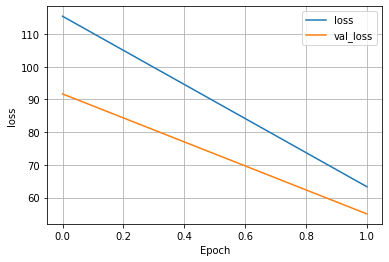

In [29]:
# Plot History
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.grid(True)
    #plt.ylim([25,50])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()

plot_loss(history)

## Test Data

Now lets see how our model performs in the test data.

In [36]:
# Evaluate test data
batch_shape = (1,) + img_shape

y_test = []
y_test_hat = []
for (cell_img, target) in test_data:
    y_test.append(target.numpy()[0])
    y_test_hat.append(model.predict(tf.reshape(cell_img, batch_shape))[0][0])
y_test = np.asarray(y_test)
y_test_hat = np.asarray(y_test_hat)

Plot distribution of errors:

Text(0.5, 1.0, 'Errors BoxPlot')

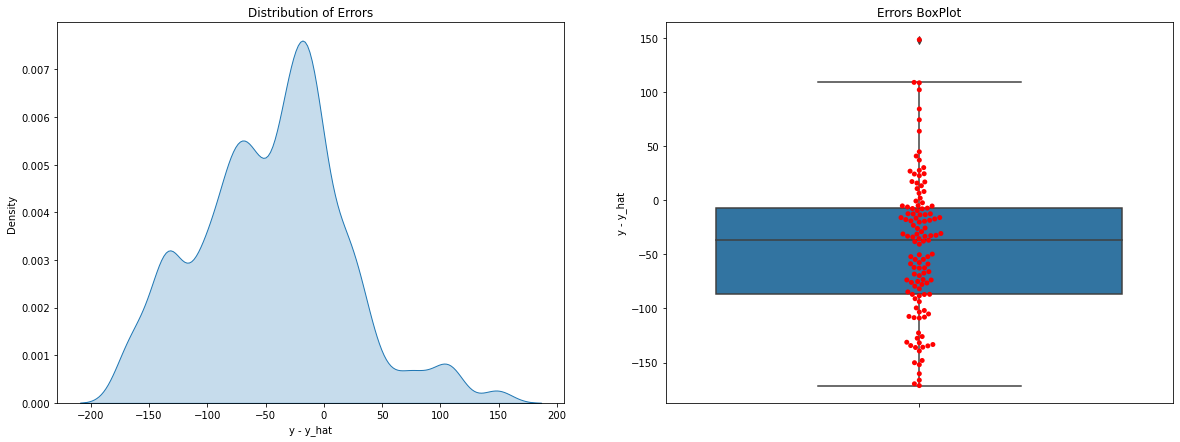

In [50]:
diff_df = pd.DataFrame(y_test.reshape((-1,1)) - y_test_hat.reshape((-1,1)), columns=['diff'])

plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
sns.kdeplot(x='diff',
            data=diff_df,
            shade=True, 
            bw_method=0.2)
plt.xlabel('y - y_hat')
plt.title('Distribution of Errors')

plt.subplot(1,2,2)
sns.boxplot(y='diff',
            data=diff_df)
sns.swarmplot(y='diff',
              color='red',
              data=diff_df)
plt.ylabel('y - y_hat')
plt.title('Errors BoxPlot')

Compare the distribution between *y* and *t_hat*:

Text(0.5, 1.0, 'Transcription Rate (TR) values distribution')

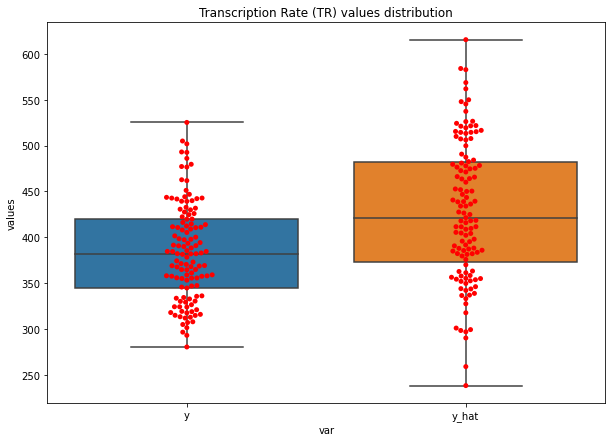

In [53]:
y_df = pd.DataFrame(y_test.reshape((-1,1)), columns=['values'])
y_df['var'] = 'y'
y_hat_df = pd.DataFrame(y_test_hat.reshape((-1,1)), columns=['values'])
y_hat_df['var'] = 'y_hat'
temp = pd.concat((y_df, y_hat_df), axis=0).reset_index()

plt.figure(figsize=(10,7))
sns.boxplot(y='values',
            x='var',
            data=temp)
sns.swarmplot(y='values',
              x='var',
              color='red',
              data=temp)
plt.title('Transcription Rate (TR) values distribution')